# Исследование `Extra Trees Classifier`

### Импорты

In [13]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

### Данные

Загрузим наши данные.

In [5]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [7]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


Выделим таргет.

In [8]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns
X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

### Функции

In [9]:
def evaluate_binary_classification(y_true, y_predicted, y_probabilities=None, threshold=0.5):
    """
    Оценивает результаты бинарной классификации и выводит метрики и графики.

    Args:
        y_true (array-like): Истинные метки классов (0 или 1).
        y_predicted (array-like): Предсказанные метки классов (0 или 1).  Если переданы вероятности, то предварительно применяем порог к ним.
        y_probabilities (array-like, optional): Предсказанные вероятности принадлежности к классу 1. Defaults to None.
        threshold (float, optional): Порог для определения класса на основе вероятностей. Defaults to 0.5.
    """

    print("=== Binary Classification Evaluation ===")

    cm = confusion_matrix(y_true, y_predicted)
    print("\nConfusion Matrix:")
    print(cm)

    accuracy = accuracy_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    recall = recall_score(y_true, y_predicted)
    f1 = f1_score(y_true, y_predicted)

    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    if y_probabilities is not None:

        roc_auc = roc_auc_score(y_true, y_probabilities)
        print(f"\nROC AUC:   {roc_auc:.4f}")

        pr_auc = average_precision_score(y_true, y_probabilities)
        print(f"PR AUC:    {pr_auc:.4f}")

        fpr, tpr, thresholds_roc = roc_curve(y_true, y_probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probabilities)

        precision = precision[:-1]
        recall = recall[:-1]

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall (PR) Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

In [10]:
def evaluate_model(model, X_test, y_test):
    """Оценивает обученную модель на тестовых данных."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    evaluate_binary_classification(y_test, y_pred)

    print("\nClassification Report:")
    print(report)

    return y_pred

In [11]:
def visualize_feature_importance(model, feature_names):
    """Визуализирует важность признаков с улучшениями."""
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 7))
    plt.title('Feature Importances', fontsize=16)
    plt.barh(range(len(indices)), importances[indices], color="#66b3ff", align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.xlim(0, np.max(importances) * 1.1)
    plt.tight_layout()
    sns.despine()
    plt.show()

def visualize_predictions(y_true, y_pred, class_names=None):
   """Визуализирует предсказанные и истинные значения."""
   cm = confusion_matrix(y_true, y_pred)
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=class_names if class_names else ['Class 0', 'Class 1'],
               yticklabels=class_names if class_names else ['Class 0', 'Class 1'])
   plt.xlabel("Predicted Label")
   plt.ylabel("True Label")
   plt.title("Confusion Matrix")
   plt.show()

In [12]:
def roc_auc(model, X_test, y_test):

    y_pred_proba = model.predict_proba(X_test)[:, 1] # Вероятности для класса 1
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {roc_auc}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

## Признак `Mortgage`.

Объявляем модель.

In [15]:
random_state=42
et_classifier_mortgage_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

Обучаем модель.

In [17]:
et_classifier_mortgage_model.fit(X_train_Mortgage, y_train_Mortgage)
et_classifier_mortgage_model_pred = evaluate_model(et_classifier_mortgage_model, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== Binary Classification Evaluation ===

Confusion Matrix:
[[316  17]
 [164 169]]

Accuracy:  0.7282
Precision: 0.9086
Recall:    0.5075
F1 Score:  0.6513

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78       333
           1       0.91      0.51      0.65       333

    accuracy                           0.73       666
   macro avg       0.78      0.73      0.71       666
weighted avg       0.78      0.73      0.71       666



Визуализируем важности признаков модели.

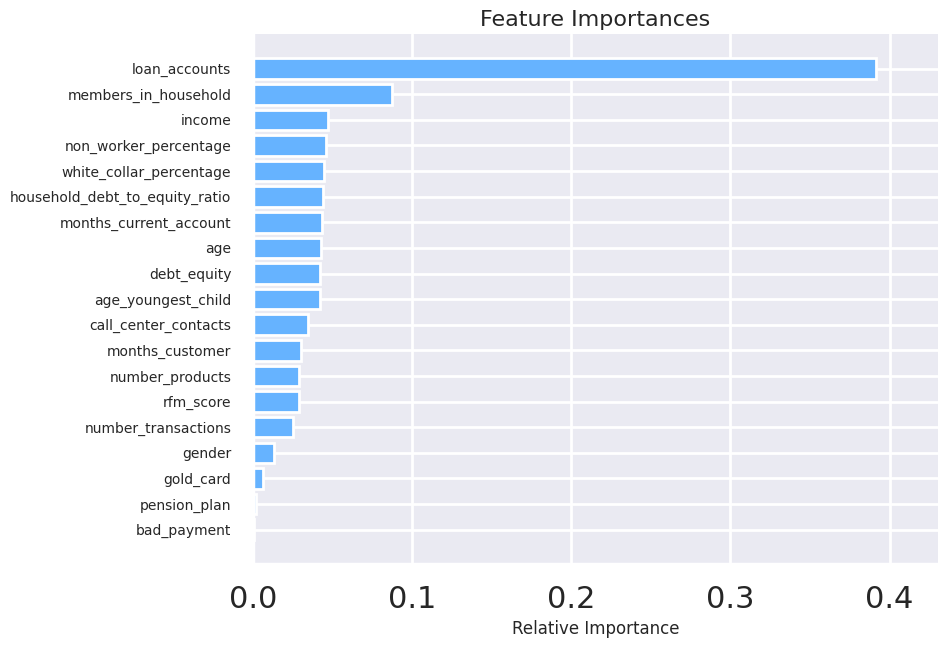

In [18]:
visualize_feature_importance(et_classifier_mortgage_model, X_train_Mortgage.columns)

#### Кривая ROC-AUC.

Посмотрим на кривую `ROC-AUC`.

AUC: 0.8664430195961728


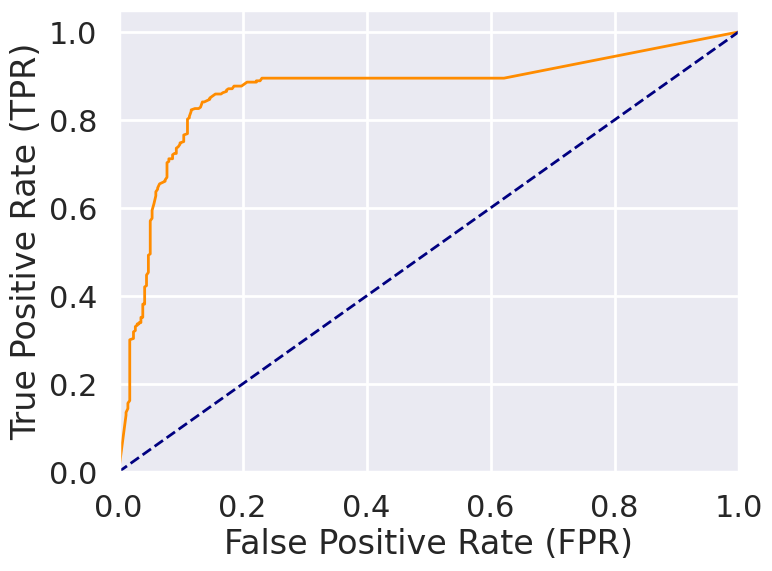

In [19]:
roc_auc(et_classifier_mortgage_model, X_val_Mortgage, y_val_Mortgage)

Посмотрим, что было у `Random Forest Classifier`.

AUC: 0.9370676983289596


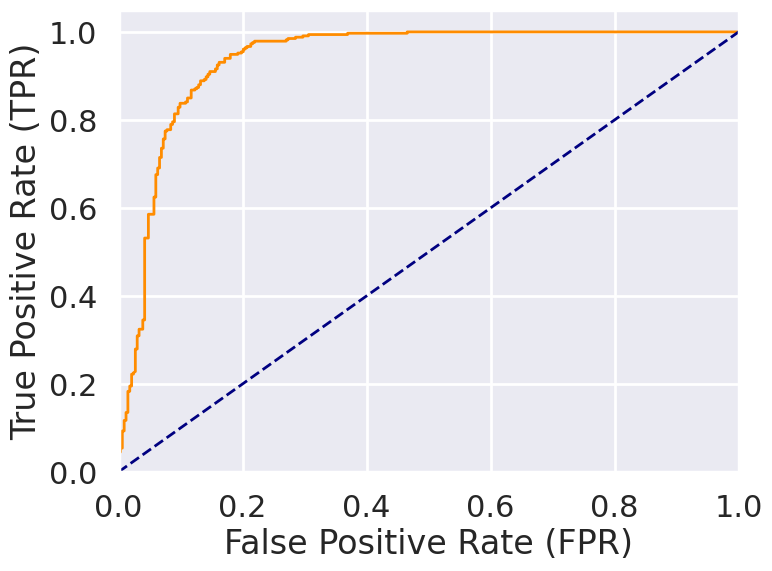

In [ ]:
roc_auc(mortgage_model, X_val_Mortgage, y_val_Mortgage)

Результат сильно хуже.

## Признак Pension.

Объявляем модель.

In [20]:
random_state=42
et_classifier_pension_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

Обучаем.

In [21]:
et_classifier_pension_model.fit(X_train_Pension, y_train_Pension)
et_classifier_pension_model_pred = evaluate_model(et_classifier_pension_model, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== Binary Classification Evaluation ===

Confusion Matrix:
[[456  35]
 [399  92]]

Accuracy:  0.5580
Precision: 0.7244
Recall:    0.1874
F1 Score:  0.2977

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.93      0.68       491
           1       0.72      0.19      0.30       491

    accuracy                           0.56       982
   macro avg       0.63      0.56      0.49       982
weighted avg       0.63      0.56      0.49       982



Важность признаков.

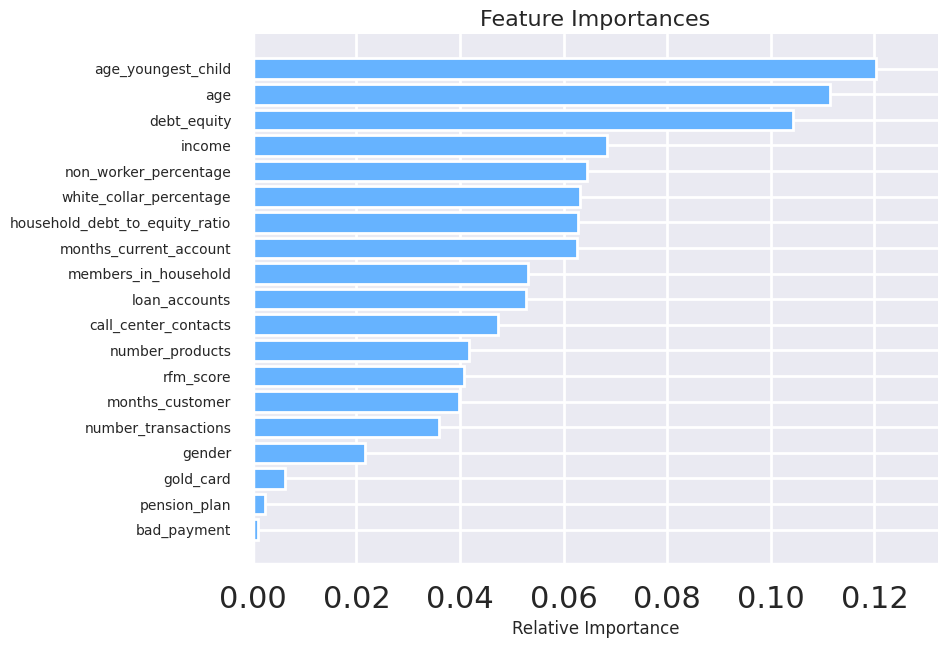

In [22]:
visualize_feature_importance(et_classifier_pension_model, X_train_Pension.columns)

#### Кривая ROC-AUC.

AUC: 0.7021955276442358


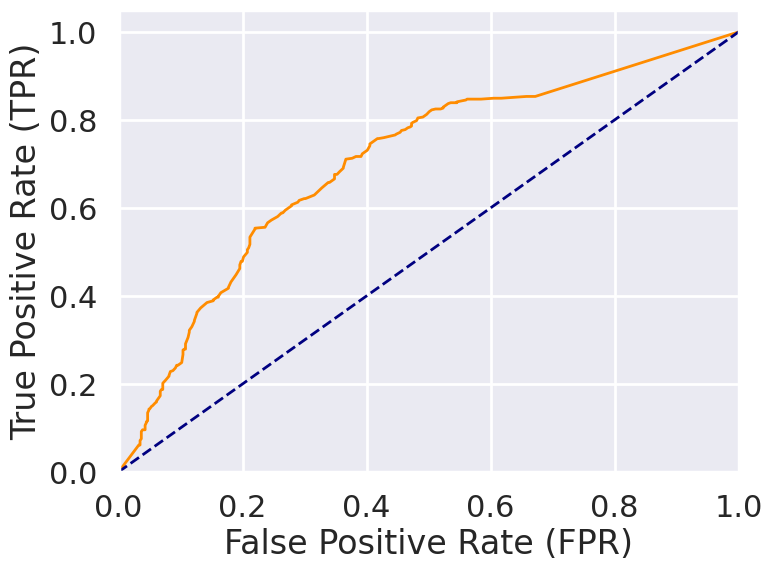

In [23]:
roc_auc(et_classifier_pension_model, X_val_Pension, y_val_Pension)

Сравним со случайным лесом.

AUC: 0.7686669625561533


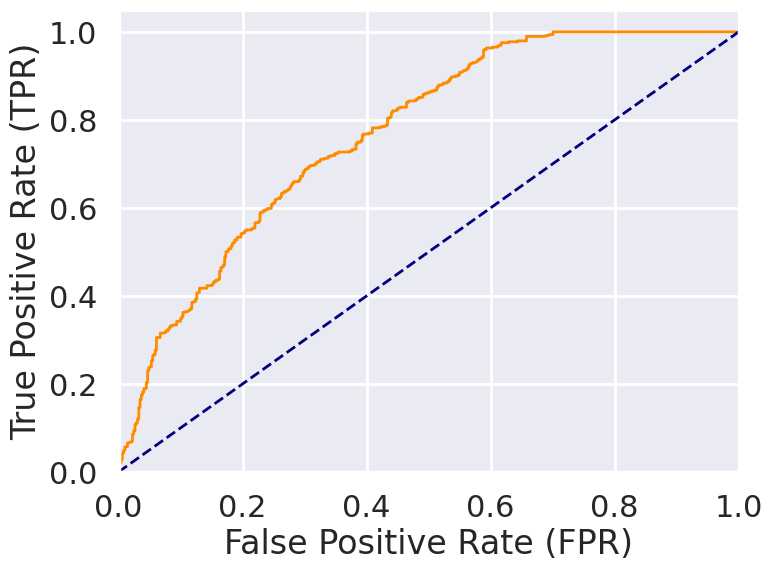

In [ ]:
roc_auc(pension_model, X_val_Pension, y_val_Pension)

Тоже хуже результат.

## Признак Savings.

Инициализируем модель.

In [24]:
random_state=42
et_classifier_savings_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

Обучаем модель, смотрим, как оно обучилось.

In [25]:
et_classifier_savings_model.fit(X_train_Savings, y_train_Savings)
et_classifier_savings_model_pred = evaluate_model(et_classifier_savings_model, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


=== Binary Classification Evaluation ===

Confusion Matrix:
[[649 196]
 [559 286]]

Accuracy:  0.5533
Precision: 0.5934
Recall:    0.3385
F1 Score:  0.4310

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.77      0.63       845
           1       0.59      0.34      0.43       845

    accuracy                           0.55      1690
   macro avg       0.57      0.55      0.53      1690
weighted avg       0.57      0.55      0.53      1690



Визуализируем важность признаков.

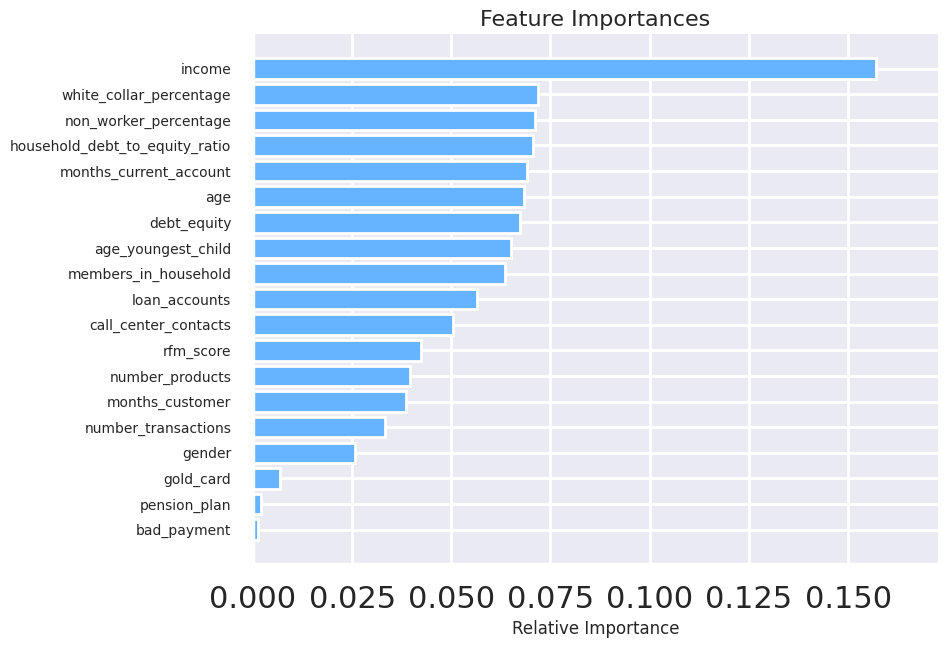

In [26]:
visualize_feature_importance(et_classifier_savings_model, X_train_Savings.columns)

#### Кривая ROC-AUC.

Строим кривую `ROC-AUC`.

AUC: 0.6077147158712931


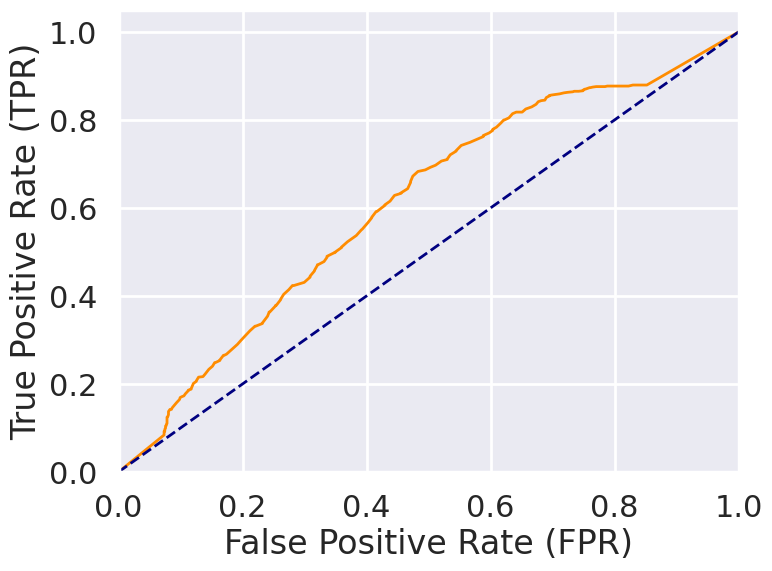

In [27]:
roc_auc(et_classifier_savings_model, X_val_Savings, y_val_Savings)

Сравним.

AUC: 0.682565036238227


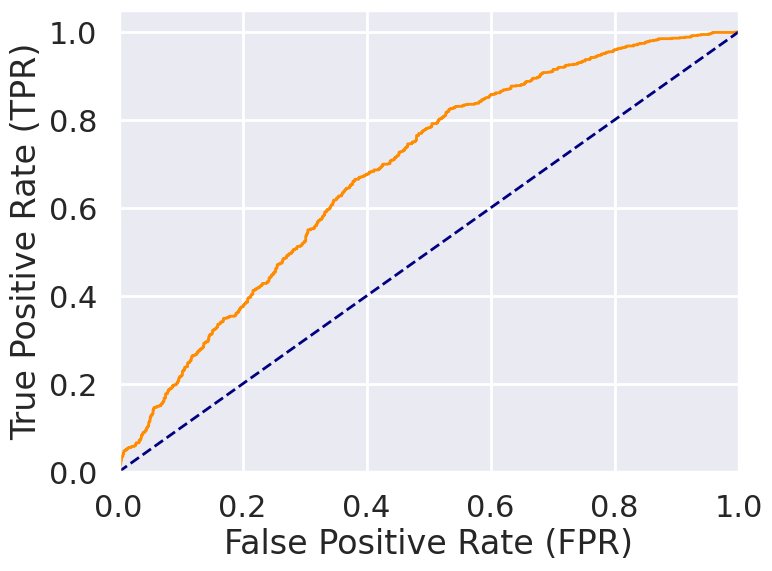

In [ ]:
roc_auc(savings_model, X_val_Savings, y_val_Savings)

Тоже ухудшилось.

### **Выводы**

Результат `Extra Trees Classifier` получились хуже, чем результат `Random Tree Classifier` для всех таргетов.